# Modeling Training and Deployment

In [376]:
import os
import re

import pandas as pd
import numpy as np
from functions import *

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, confusion_matrix

from imblearn.over_sampling import SMOTE

import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import RegexpTokenizer
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer 

import matplotlib.pyplot as plt

In [377]:
df = pd.read_csv('data/article_archive.csv')
df.dropna(inplace=True)
df_most_shared = load_most_shared('data/most_popular')

In [378]:
popular_list = df_most_shared.uri.values
df['popular'] = [1 if x in popular_list else 0 for x in df['uri']]

In [379]:
df.head()

,uri,date_published,headline,keywords,snippet,word_count,popular
0,nyt://article/4e2abcbc-9563-56c0-bf18-c93ce4e7...,2021-12-01T00:00:07+0000,let’s end the covid blame games,coronavirus omicron variantcoronavirus (2019-n...,"Finger pointing is pointless, divisive and dumb.",918,0
1,nyt://article/f7a5e7ef-e4cd-575c-a0e1-ff4d18d5...,2021-12-01T00:00:07+0000,trump’s iran policy has become a disaster for ...,irannuclear weaponsembargoes and sanctionsunit...,Withdrawing from the Iran nuclear deal was a m...,1560,0
2,nyt://article/778af86c-b600-5aeb-be98-0a9a1aa1...,2021-12-01T00:00:10+0000,this extinct eagle may have gulped guts like a...,eagles (birds)vultures (birds)condorsendangere...,Scientists suggest the largest eagle that ever...,913,0
3,nyt://article/fb7763c2-0f41-5c81-9ecf-17607ba5...,2021-12-01T00:14:33+0000,republican recriminations point to a rocky pat...,republican partyhouse of representativesboeber...,Simmering tensions between the far-right flank...,1172,0
4,nyt://article/ba0afd37-0c00-5535-8868-21130e28...,2021-12-01T00:17:02+0000,a times editor who attended oxford recalls a d...,school shootings and armed attacks,Three teenage students were killed on Tuesday ...,309,0


In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4564 entries, 0 to 5095
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   uri             4564 non-null   object
 1   date_published  4564 non-null   object
 2   headline        4564 non-null   object
 3   keywords        4564 non-null   object
 4   snippet         4564 non-null   object
 5   word_count      4564 non-null   int64 
 6   popular         4564 non-null   int64 
dtypes: int64(2), object(5)
memory usage: 285.2+ KB


In [381]:
df.popular.value_counts()

0    4513
1      51
Name: popular, dtype: int64

## Train-Test Split

In [382]:
X = df.drop('popular', axis=1)
y = df.popular

In [383]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.25)

## Dummy classifier

In [384]:
dummy = DummyClassifier(random_state=0, strategy='stratified') 

#establishing random_state for reproducibility

dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

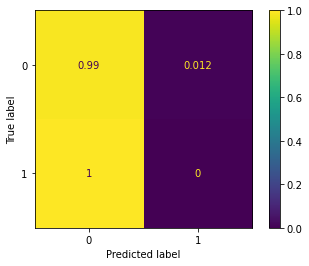

In [385]:
plot_confusion_matrix(estimator=dummy, X=X_test, y_true=y_test, normalize='true');

In [386]:
print("Accuracy Score: {}".format(accuracy_score(y_test, y_pred)))

Accuracy Score: 0.978965819456617


## Data Preprocessing 

In [430]:
def vectorize_feature(vectorizer, X_train, X_test ):
    sw = stopwords.words('english')
    vectorizer = vectorizer(stop_words=sw)
    
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    return vectorizer, X_train_vec, X_test_vec

In [439]:
def plot_top_words(vectorizer, X_train):
    
    df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names())
    limit = 10

    plt.figure(figsize=(8,10))
    plot = plt.barh(df.sum().sort_values(ascending=False)[:limit].index, 
             df.sum().sort_values(ascending=False)[:limit]);
    
    return plot

In [452]:
def vector_tokenized(vectorizer, X_train, X_test):
    sw = stopwords.words('english')
    
    vector_tokenized = [text_prep(text, sw) for text in X_train]
    X_train_token_vec = vectorizer.fit_transform(vector_tokenized)
    X_test_token_vec = vectorizer.transform(X_test)
    
    return X_train_token_vec, X_test_token_vec
    

#### Headline

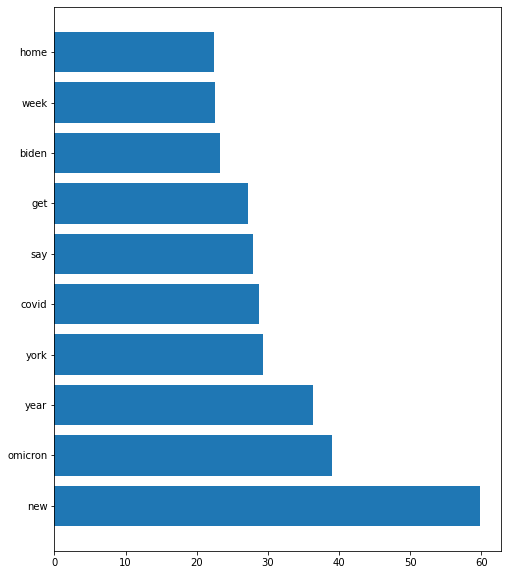

In [465]:
headline_tf, X_train_headline_tf, X_test_headline_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.headline, X_test.headline)

X_train_headline_tf, X_test_headline_tf = vector_tokenized(headline_tf, X_train.headline, X_test.headline)


X_train_headline_tf_sm, y_train_headline_tf_sm = smote_data(X_train_headline_tf, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_headline_tf_sm, y_train_headline_tf_sm, X_test_headline_tf

plot_top_words(headline_tf, X_train_headline_tf);

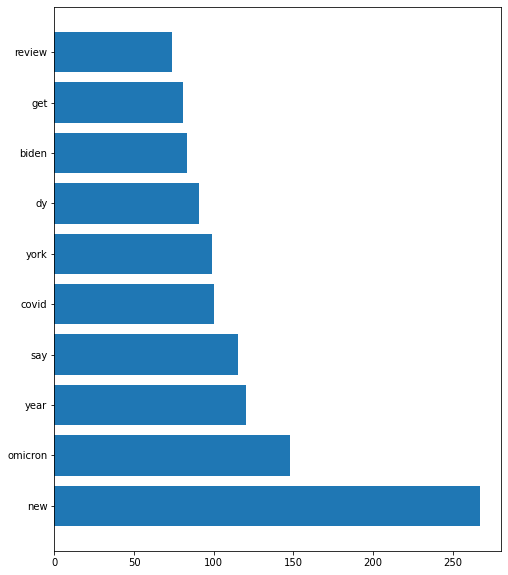

In [466]:
headline_cv, X_train_headline_cv, X_test_headline_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.headline, X_test.headline)

X_train_headline_cv, X_test_headline_cv = vector_tokenized(headline_cv, X_train.headline, X_test.headline)

X_train_headline_cv_sm, y_train_headline_cv_sm = smote_data(X_train_headline_cv, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_headline_cv_sm, y_train_headline_cv_sm, X_test_headline_cv

plot_top_words(headline_cv, X_train_headline_cv);

#### Keywords

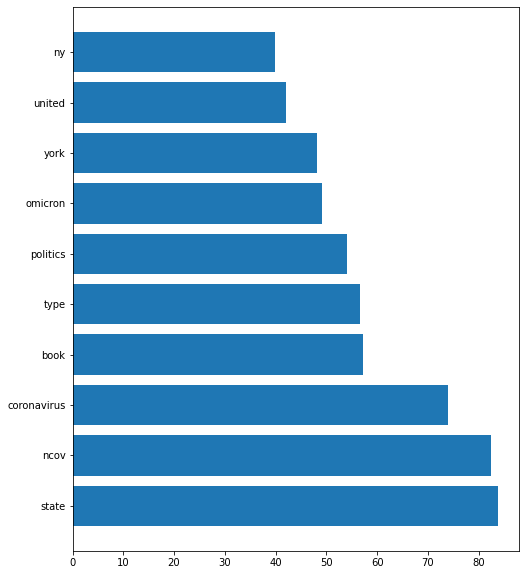

In [467]:
keywords_tf, X_train_keywords_tf, X_test_keywords_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.keywords, X_test.keywords)

X_train_keywords_tf, X_test_keywords_tf = vector_tokenized(keywords_tf, X_train.keywords, X_test.keywords)

X_train_keywords_tf_sm, y_train_keywords_tf_sm = smote_data(X_train_keywords_tf, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_keywords_tf_sm, y_train_keywords_tf_sm, X_test_keywords_tf

plot_top_words(keywords_tf, X_train_keywords_tf);

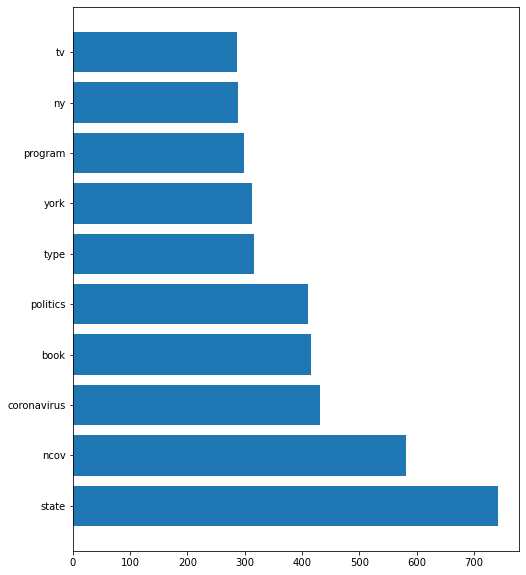

In [468]:
keywords_cv, X_train_keywords_cv, X_test_keywords_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.keywords, X_test.keywords)

X_train_keywords_cv, X_test_keywords_cv = vector_tokenized(keywords_cv, X_train.keywords, X_test.keywords)

X_train_keywords_cv_sm, y_train_keywords_cv_sm = smote_data(X_train_keywords_cv, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_keywords_cv_sm, y_train_keywords_cv_sm, X_test_keywords_cv

plot_top_words(keywords_cv, X_train_keywords_cv);

#### Snippet

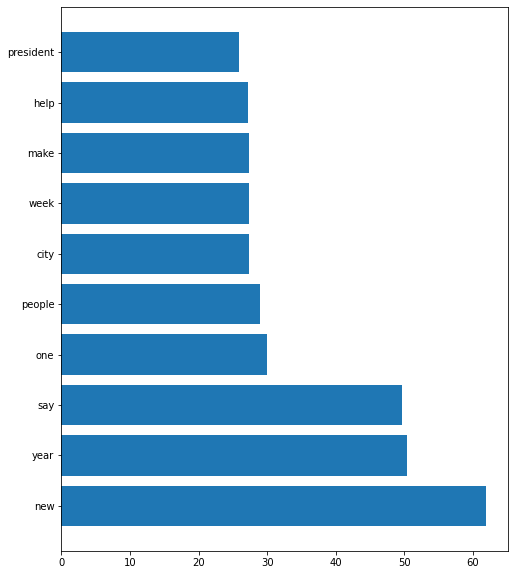

In [469]:
snippet_tf, X_train_snippet_tf, X_test_snippet_tf = vectorize_feature(TfidfVectorizer, 
                                                                         X_train.snippet, X_test.snippet)

X_train_snippet_tf, X_test_snippet_tf = vector_tokenized(snippet_tf, X_train.snippet, X_test.snippet)

X_train_snippet_tf_sm, y_train_snippet_tf_sm = smote_data(X_train_snippet_tf, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_snippet_tf_sm, y_train_snippet_tf_sm, X_test_snippet_tf

plot_top_words(snippet_tf, X_train_snippet_tf);

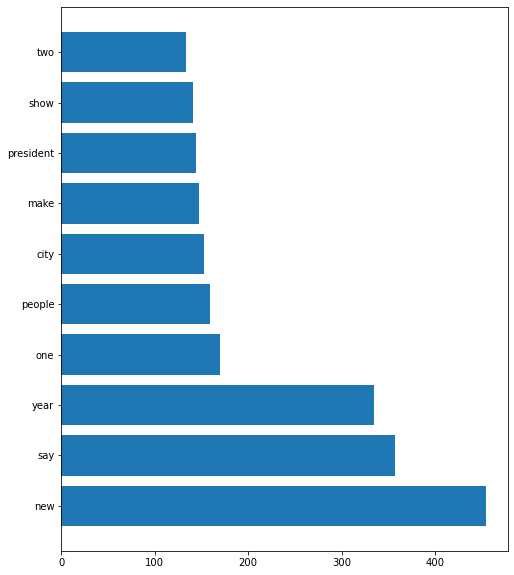

In [470]:
snippet_cv, X_train_snippet_cv, X_test_snippet_cv = vectorize_feature(CountVectorizer, 
                                                                         X_train.snippet, X_test.snippet)

X_train_snippet_cv, X_test_snippet_cv = vector_tokenized(snippet_cv, X_train.snippet, X_test.snippet)

X_train_snippet_cv_sm, y_train_snippet_cv_sm = smote_data(X_train_snippet_cv, y_train, 
                                                  sampling_strategy='auto',random_state=0)

# used later: X_train_snippet_cv_sm, y_train_snippet_cv_sm, X_test_snippet_cv

plot_top_words(snippet_cv, X_train_snippet_cv);

#### Word Count

In [471]:
X_train_word_count_sm, y_train_word_count_sm = smote_data(X_train.word_count.values.reshape(-1, 1), 
                                                          y_train, sampling_strategy='auto',
                                                          random_state=0)

## Modeling

In [478]:
def random_forrest(X_train, y_train, X_test, y_test):
    
    forrest = RandomForestClassifier()
    grid = {'n_estimators': [50,75,100]}
    
    gs = GridSearchCV(estimator=forrest, param_grid=grid, cv=5, scoring='accuracy')
    gs.fit(X_train, y_train)

    score = gs.score(X_test, y_test)
    print(f'mean accuracy: {score}')
    
    class_probability = gs.predict_proba(X_test)
    target_probability = [x[1] for x in class_probability]
    
    # Plot an ROC curve (only works with binary data)
    fig, ax = plt.subplots()
    plt.title('ROC Curve')
    plot_roc_curve(gs, X_train, y_train, name='Train', ax=ax)
    plot_roc_curve(gs, X_test, y_test, name='Test', ax=ax)
    
    # Plot Confusion Matrix
    plot_confusion_matrix(gs, X_test, y_test)
    
    return target_probability

#### Headline

##### TfidfVectorizer

mean accuracy: 0.9894829097283085
number of probabilities: 1141



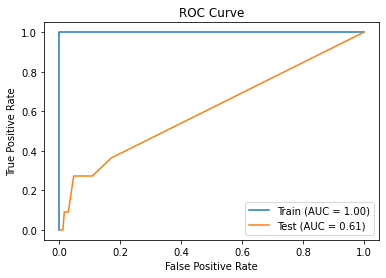

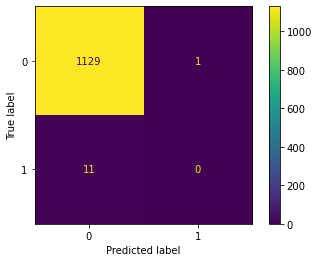

In [479]:
headline_tf_prob = random_forrest(X_train_headline_tf_sm, y_train_headline_tf_sm, X_test_headline_tf, y_test)
print(f'number of probabilities: {len(headline_tf_prob)}')
print()

##### CountVectorizer

mean accuracy: 0.7730061349693251
number of probabilities: 1141



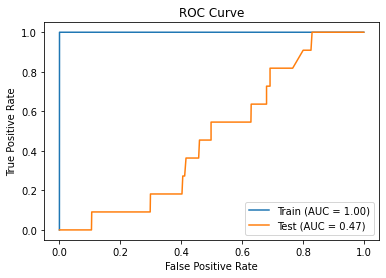

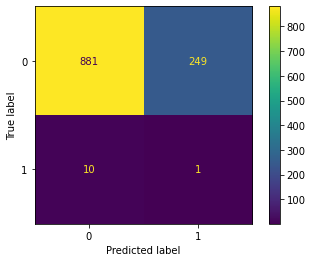

In [480]:
headline_cv_prob = random_forrest(X_train_headline_cv_sm, y_train_headline_cv_sm, X_test_headline_cv, y_test)
print(f'number of probabilities: {len(headline_cv_prob)}')
print()

#### Keywords

mean accuracy: 0.9894829097283085
number of probabilities: 1141



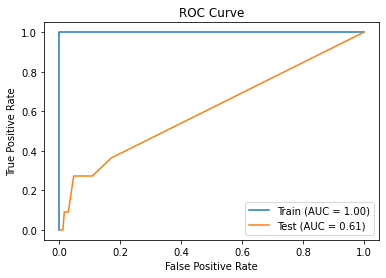

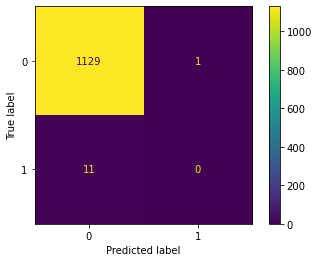

In [479]:
headline_tf_prob = random_forrest(X_train_headline_tf_sm, y_train_headline_tf_sm, X_test_headline_tf, y_test)
print(f'number of probabilities: {len(headline_tf_prob)}')
print()

##### CountVectorizer

mean accuracy: 0.7730061349693251
number of probabilities: 1141



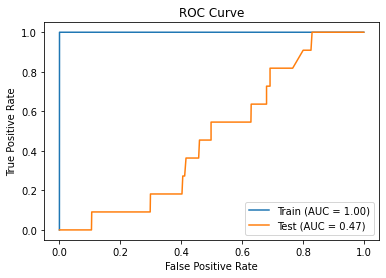

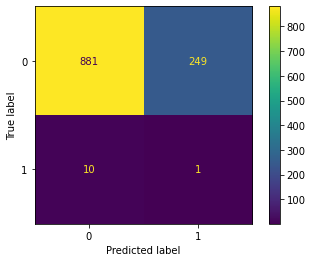

In [480]:
headline_cv_prob = random_forrest(X_train_headline_cv_sm, y_train_headline_cv_sm, X_test_headline_cv, y_test)
print(f'number of probabilities: {len(headline_cv_prob)}')
print()

In [319]:
# Create the random grid
keywords_grid = {'n_estimators': [50,75,100]}

## Snippet Random Forrest

In [331]:
forest_snippet = RandomForestClassifier()

In [332]:
# Create the random grid
snippet_grid = {'n_estimators': [50,75,100]}

In [333]:
# Instantiate & fit GridSearchCV with accuracy scoring
gs_snippet = GridSearchCV(estimator=forest_snippet, param_grid=snippet_grid, cv=5, scoring='accuracy')
gs_snippet.fit(X_train_snippet_sm, y_train_snippet_sm)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': [50, 75, 100]}, scoring='accuracy')

In [334]:
gs_snippet.best_params_

{'n_estimators': 100}

In [335]:
snippet_prob = gs_snippet.predict_proba(X_test_snippet_vec)
snippet_prob = [x[1] for x in snippet_prob]
len(snippet_prob)

1141

In [336]:
gs_snippet.best_estimator_.classes_

array([0, 1])

In [337]:
max(snippet_prob)

1.0

## Word Count Logistic

In [345]:
clf_word_count = LogisticRegression()

In [346]:
clf_word_count.fit(X_train_word_count_sm, y_train_word_count_sm)

LogisticRegression()

In [347]:
word_count_prob = clf_word_count.predict_proba(X_test.word_count.values.reshape(-1, 1))
word_count_prob = [x[1] for x in word_count_prob]
len(word_count_prob)

1141

In [348]:
max(word_count_prob)

0.7491310076735012

### Logistic Regression

In [349]:
df_predict = pd.DataFrame({'headline_prob': headline_prob, 
                           'keywords_prob': headline_prob, 
                           'snippet_prob': snippet_prob,
                           'word_count_prob': word_count_prob, 
                           'popular': y_test})

In [350]:
df_predict.head()

,headline_prob,keywords_prob,snippet_prob,word_count_prob,popular
2177,0.420000,0.420000,0.04,0.468788,0
1480,0.000000,0.000000,0.07,0.508206,0
2422,0.119974,0.119974,1.00,0.456294,0
3821,0.680000,0.680000,0.00,0.523595,0
3698,0.140000,0.140000,0.12,0.480290,0


In [351]:
df_predict.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1141 entries, 2177 to 3540
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   headline_prob    1141 non-null   float64
 1   keywords_prob    1141 non-null   float64
 2   snippet_prob     1141 non-null   float64
 3   word_count_prob  1141 non-null   float64
 4   popular          1141 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 53.5 KB


In [352]:
features = df_predict.drop('popular', axis=1)
target = df_predict.popular

In [353]:
clf = LogisticRegression()

In [354]:
clf.fit(features, target)

LogisticRegression()

In [ ]:
clf.predict()